In [1]:
from pysqlite2 import dbapi2 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/eric/anaconda2/envs/geo/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
qry = '''
SELECT
A.STATE,
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*,
C.metro,
C.econdep,
D.pwhite_10,
D.pwhite_00,
D.pwhite_90,
E.AX7AA1990 * 1.0 / (E.AX7AA1990 + E.AX7AB1990) AS povrate90,
E.AX7AA2000 * 1.0 / (E.AX7AA2000 + E.AX7AB2000) AS povrate00,
E.AX7AA125 * 1.0 / (E.AX7AA125 + E.AX7AB125) AS povrate125
FROM nhgis_pop_race_norm_90_10 AS A
JOIN county_gini AS B ON A.GISJOIN = B.GISJOIN
JOIN usda_typology_2004 AS C
    ON  A.STATEA || A.COUNTYA = C.FIPSTXT
JOIN county_diversity AS D 
    ON A.GISJOIN = D.GISJOIN
JOIN county_poverty AS E
    ON A.GISJOIN = E.GISJOIN
WHERE A.STATE NOT IN ('Alaska', 'Hawaii', 'District Of Columbia')
;
'''
df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
print len(df)

3108


In [30]:
df.STATE.unique()

array([u'Alabama', u'Arizona', u'Arkansas', u'California', u'Colorado',
       u'Connecticut', u'Delaware', u'Florida', u'Georgia', u'Idaho',
       u'Illinois', u'Indiana', u'Iowa', u'Kansas', u'Kentucky',
       u'Louisiana', u'Maine', u'Maryland', u'Massachusetts', u'Michigan',
       u'Minnesota', u'Mississippi', u'Missouri', u'Montana', u'Nebraska',
       u'Nevada', u'New Hampshire', u'New Jersey', u'New Mexico',
       u'New York', u'North Carolina', u'North Dakota', u'Ohio',
       u'Oklahoma', u'Oregon', u'Pennsylvania', u'Rhode Island',
       u'South Carolina', u'South Dakota', u'Tennessee', u'Texas', u'Utah',
       u'Vermont', u'Virginia', u'Washington', u'West Virginia',
       u'Wisconsin', u'Wyoming'], dtype=object)

In [31]:
# merge with census regions
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT A.gisjoin, B.name AS region
FROM us_county_2010 AS A, census_regions_10 AS B
WHERE ST_Contains(B.geometry, ST_Centroid(A.geometry))
AND A.ROWID IN (SELECT ROWID FROM SpatialIndex
    WHERE f_table_name = 'us_county_2010' AND search_frame = B.geometry )
;
'''

df2 = pd.read_sql(qry, con, index_col='gisjoin')
con.close()
df = pd.merge(df, df2, left_index=True, right_index=True)
print len(df)

3105


In [4]:
# create categories for pop change 2000 to 2010
# calc pop change in each decade
df['ppctchg_0010'] = ( df['pop10'] - df['pop00'] ) * 1.0 / df['pop00'] * 100
df['ppctchg_9000'] = ( df['pop00'] - df['pop90'] ) * 1.0 / df['pop90'] * 100
# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0010'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0010'] < 5) & (df['ppctchg_0010'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0010'] < 0, 'growth_cat'] = 'shrinking'
# growth categories 1990-2000
df['growth_cat_90s'] = 0
df.loc[df['ppctchg_9000'] >= 5, 'growth_cat_90s'] = 'growing'
df.loc[(df['ppctchg_9000'] < 5) & (df['ppctchg_9000'] >= 0 ), 'growth_cat_90s'] = 'stable'
df.loc[df['ppctchg_9000'] < 0, 'growth_cat_90s'] = 'shrinking'
# xtab counties between 1990s and 2000s in terms of pop change category
pd.crosstab(df['growth_cat_90s'], df['growth_cat'], margins=True)

growth_cat,growing,shrinking,stable,All
growth_cat_90s,,,,
growing,1184,288,454,1926
shrinking,46,530,99,675
stable,55,269,183,507
All,1285,1087,736,3108


In [5]:
# gen outcome vars
df['gini_diff_9000'] = df['gini_00'] - df['gini_90']
df['gini_diff_0010'] = df['gini_10'] - df['gini_00']

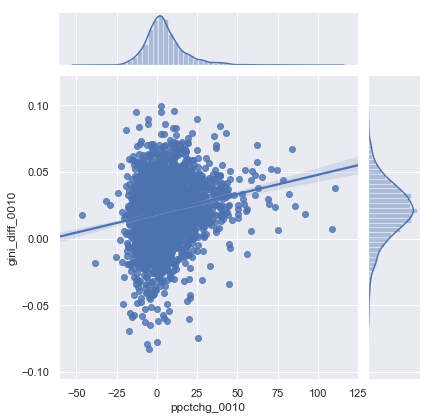

In [6]:
# plot difference in segregation score against percent pop change for both periods
sns.jointplot('ppctchg_0010', 'gini_diff_0010', df, kind='reg')

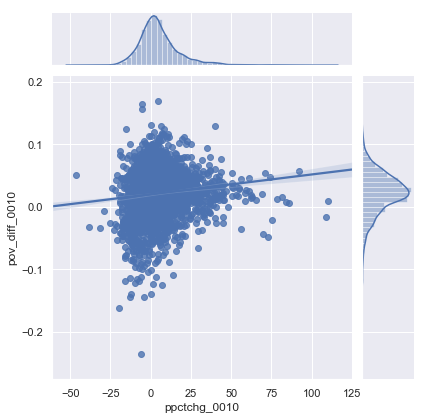

In [9]:
df['pov_diff_0010'] = df['povrate125'] - df['povrate00']
sns.jointplot('ppctchg_0010', 'pov_diff_0010', df, kind='reg')

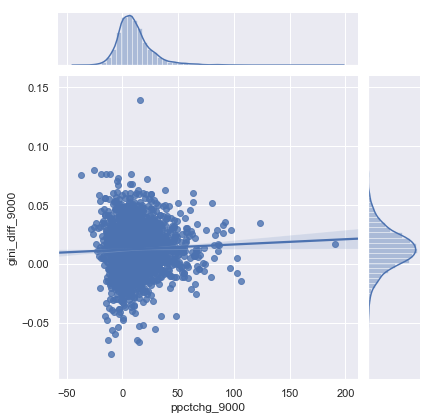

In [35]:
# plot difference in segregation score against percent pop change for both periods
sns.jointplot('ppctchg_9000', 'gini_diff_9000', df, kind='reg')

Text(0.5,1,u'2000-2010')

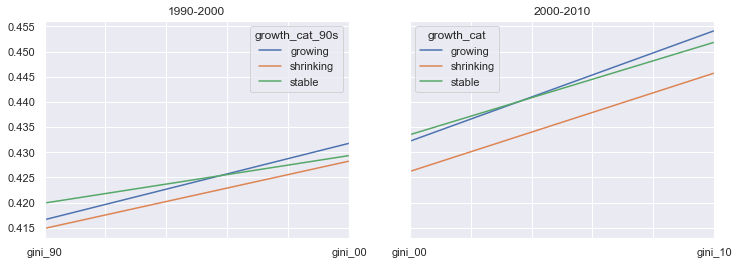

In [36]:
# plot change in median diversity across periods
# calculated using four groups
w = 12
h = 4
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
cols1 = ['gini_90', 'gini_00']
cols2 = ['gini_00', 'gini_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

In [37]:
# base model = diff in ineq on pop pct change
m = 'gini_diff_0010 ~ ppctchg_0010'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         gini_diff_0010   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     91.35
Date:                Tue, 16 Oct 2018   Prob (F-statistic):           2.36e-21
Time:                        22:30:57   Log-Likelihood:                 7493.7
No. Observations:                3104   AIC:                        -1.498e+04
Df Residuals:                    3102   BIC:                        -1.497e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0189      0.000     43.261   

In [38]:
# regress change in specialization (t2 - t1)  on pop change
m = 'gini_diff_0010 ~ ppctchg_0010 + np.log(pop00) + pwhite_00 + gini_00 + STATE + region'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         gini_diff_0010   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     18.60
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          1.05e-148
Time:                        22:30:57   Log-Likelihood:                 7921.0
No. Observations:                3104   AIC:                        -1.574e+04
Df Residuals:                    3051   BIC:                        -1.542e+04
Df Model:                          52                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [39]:
# regress change in specialization (t2 - t1)  on pop change
m = 'gini_diff_9000 ~ ppctchg_9000 + np.log(pop90) + pwhite_90 + gini_90 + STATE + region'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         gini_diff_9000   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     25.67
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          1.04e-205
Time:                        22:30:57   Log-Likelihood:                 8812.9
No. Observations:                3103   AIC:                        -1.752e+04
Df Residuals:                    3050   BIC:                        -1.720e+04
Df Model:                          52                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# piecewise regression

In [40]:
# create piecewise variables
# gen new var with increasing values for pop change tracts alone
df['pop_loss'] = 0
df.loc[df['ppctchg_0010'] < 0, 'pop_loss'] = df['ppctchg_0010'] * -1
df['intl'] = 1
df.loc[df['ppctchg_0010'] >= 0, 'intl'] = 0

df['pop_gain'] = 0
df.loc[df['ppctchg_0010'] >= 0, 'pop_gain'] = df['ppctchg_0010']
df['intg'] = 1
df.loc[df['ppctchg_0010'] < 0, 'intg'] = 0

In [42]:
# regress change in specialization (t2 - t1)  on pop change
m = 'gini_diff_0010 ~ pop_loss + pop_gain + pop00 + pwhite_00 + gini_00 + STATE + region'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         gini_diff_0010   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     15.02
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          3.93e-120
Time:                        22:32:30   Log-Likelihood:                 7825.3
No. Observations:                3104   AIC:                        -1.554e+04
Df Residuals:                    3050   BIC:                        -1.522e+04
Df Model:                          53                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# predicted values

In [56]:
# generate new vars for prediction 
df['pop00_ln'] = np.log(df['pop00'])

dummy_regions = pd.get_dummies(df['region'], prefix='region')

cols_to_keep = ['gini_diff_0010', 'ppctchg_0010', 'pop00_ln', 'pwhite_00']
data = df[cols_to_keep].join(dummy_regions.loc[:, 'region_Northeast':])

data = data.dropna()

data['intercept'] = 1.0
data.head()

,gini_diff_0010,ppctchg_0010,pop00_ln,pwhite_00,region_Northeast,region_South,region_West,intercept
G0100010,0.013496,24.953919,10.684483,0.797373,0,1,0,1.0
G0100030,0.019744,29.804508,11.852358,0.860791,0,1,0,1.0
G0100050,-0.006408,-5.447358,10.276390,0.509257,0,1,0,1.0
G0100070,0.004886,10.028565,9.943977,0.762032,0,1,0,1.0
G0100090,0.008622,12.333062,10.840142,0.921117,0,1,0,1.0


In [57]:
# remove DV from dataframe to supply to reg model
train_cols = data.columns[1:]

In [58]:
# run model
results = sm.OLS(data['gini_diff_0010'], data[train_cols]).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         gini_diff_0010   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     64.02
Date:                Tue, 16 Oct 2018   Prob (F-statistic):           3.47e-75
Time:                        22:37:11   Log-Likelihood:                 7658.7
No. Observations:                3104   AIC:                        -1.530e+04
Df Residuals:                    3097   BIC:                        -1.526e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ppctchg_0010         0.0002   3.34e-05  

In [59]:
# create dataframe of values based on model results

def cartesian(arrays, out=None):

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [60]:
pop_chgs = np.linspace(data['ppctchg_0010'].min(), data['ppctchg_0010'].max(), 10)
print pop_chgs

[ -46.604856    -29.16527687  -11.72569773    5.7138814    23.15346054
   40.59303967   58.03261881   75.47219794   92.91177708  110.35135621]


In [61]:
# take median 2000 population
np.log(df['pop00'].median())

10.11795356265665

In [62]:
# take median pct white in 2000
df['pwhite_00'].median()

0.8934603433649365

In [63]:
# enumerate all possibilities
combos = pd.DataFrame(cartesian([pop_chgs, [0.90], [1, 2, 3, 4], [ 1. ], [10]]))
combos.columns = ['ppctchg_0010', 'pwhite_00', 'region', 'intercept', 'pop00_ln']
combos.head()

,ppctchg_0010,pwhite_00,region,intercept,pop00_ln
0,-46.604856,0.9,1.0,1.0,10.0
1,-46.604856,0.9,2.0,1.0,10.0
2,-46.604856,0.9,3.0,1.0,10.0
3,-46.604856,0.9,4.0,1.0,10.0
4,-29.165277,0.9,1.0,1.0,10.0


In [64]:
# recreate the dummy variables
dummy_ranks = pd.get_dummies(combos['region'], prefix='region')
dummy_ranks.columns = ['region_Midwest', 'region_Northeast', 'region_South', 'region_West']
# keep only what we need for making predictions
cols_to_keep = ['ppctchg_0010', 'pwhite_00', 'region', 'intercept', 'pop00_ln']
combos = combos[cols_to_keep].join(dummy_ranks.loc[:, 'region_Northeast':])
combos.head()

,ppctchg_0010,pwhite_00,region,intercept,pop00_ln,region_Northeast,region_South,region_West
0,-46.604856,0.9,1.0,1.0,10.0,0,0,0
1,-46.604856,0.9,2.0,1.0,10.0,1,0,0
2,-46.604856,0.9,3.0,1.0,10.0,0,1,0
3,-46.604856,0.9,4.0,1.0,10.0,0,0,1
4,-29.165277,0.9,1.0,1.0,10.0,0,0,0


In [65]:
# make predictions on the enumerated dataset
combos['dif_div_pred'] = results.predict(combos[train_cols])

In [66]:
grouped = pd.pivot_table(combos, values=['dif_div_pred'], index=['ppctchg_0010', 'region'], aggfunc=np.mean)
print grouped.head()

                     dif_div_pred
ppctchg_0010 region              
-46.604856   1.0         0.014892
             2.0         0.011155
             3.0         0.006318
             4.0         0.011248
-29.165277   1.0         0.018230


(-0.083107436033454996, 0.099872959640491976)

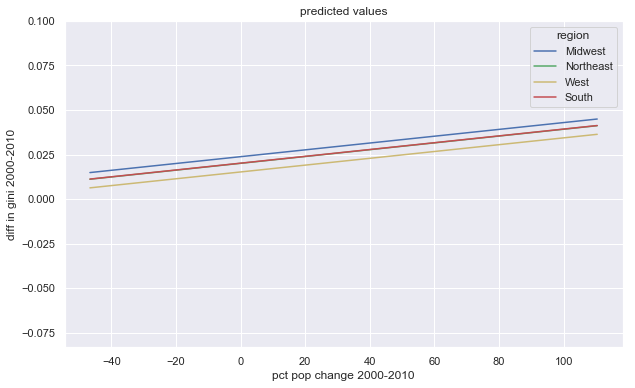

In [67]:
fix, ax = plt.subplots(figsize=(10,6))
colors = 'rbgyrbgy'
for col in combos.region.unique():
    plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
    plt.plot(plt_data.index.get_level_values(0), plt_data['dif_div_pred'], color=colors[int(col)])
    
plt.legend(['Midwest', 'Northeast', 'West', 'South'], loc='upper right', title='region')
plt.xlabel('pct pop change 2000-2010')
plt.ylabel('diff in gini 2000-2010')
plt.title('predicted values')

plt.ylim(df['gini_diff_0010'].min(), df['gini_diff_0010'].max())